In [116]:
import os
import pandas as pd
import numpy as np
import pydicom
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import pickle
import numbers
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import DataLoader, random_split, Dataset
from transformers import CLIPModel, CLIPTokenizer, CLIPProcessor
import torch
from PIL import Image
import torch.nn.functional as F

torch.manual_seed(42)
np.random.seed(42)

In [117]:
#Default CLIP feature extractor
#Load the pretrained Model
model_name = "openai/clip-vit-large-patch14"

model = CLIPModel.from_pretrained(model_name)
tokenizer = CLIPTokenizer.from_pretrained(model_name)
device = "cuda:1" if torch.cuda.is_available() else "cpu"
processor = CLIPProcessor.from_pretrained(model_name)

weights=torch.load('../../RadCLIP/Models/RadCLIP.pth',map_location=device)
model.load_state_dict(weights)
print("Model Weights loaded")

model= model.to(device)
model.eval()



def get_image_features_clip_batch(image, model, processor, device):
    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt", do_rescale=True).to(device)
        outputs = model.vision_model(**inputs)
        vision_features = outputs.pooler_output
        vision_projections = model.visual_projection(vision_features)
    return vision_features.detach().cpu(),vision_projections.detach().cpu()

def get_text_features(text):
    text = tokenizer(text, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_features = model.get_text_features(**text).to("cpu")
    return text_features

Model Weights loaded


In [118]:
def process_image(file_path):
    # Determine file type
    _, ext = os.path.splitext(file_path)
    ext = ext.lower()

    # Load image
    if ext in ['.jpg', '.jpeg']:
        image = Image.open(file_path).convert('RGB')
    elif ext == '.png':
        image = Image.open(file_path).convert('RGB')  # Convert to 3 channels
    elif ext == '.dicom':
        dicom_image = pydicom.dcmread(file_path)
        image_array = dicom_image.pixel_array
        if len(image_array.shape) == 2:  # Single-channel
            image_array = np.stack((image_array,)*3, axis=-1)
        image = Image.fromarray(image_array)
    else:
        raise ValueError("Unsupported file format")

    return image

In [119]:
def read_img(img):
    img = Image.fromarray((img * 255).astype('uint8'))
    img = img.convert('RGB')
    return img

In [120]:
dataset_file="../Data/Testing/Others/VQA/VQA_RAD Dataset Public 315 Organ and Region.csv"


In [121]:
df=pd.read_csv(dataset_file)

In [122]:
df.head()

,image_name,image_organ,refined_modality
0,synpic21604.jpg,ABDOMEN,CT
1,synpic22794.jpg,ABDOMEN,CT
2,synpic26697.jpg,ABDOMEN,CT
3,synpic32981.jpg,ABDOMEN,CT
4,synpic33892.jpg,ABDOMEN,CT


In [123]:
df

,image_name,image_organ,refined_modality
0,synpic21604.jpg,ABDOMEN,CT
1,synpic22794.jpg,ABDOMEN,CT
2,synpic26697.jpg,ABDOMEN,CT
3,synpic32981.jpg,ABDOMEN,CT
4,synpic33892.jpg,ABDOMEN,CT
...,...,...,...
309,synpic59935.jpg,HEAD,NaN
310,synpic60096.jpg,HEAD,NaN
311,synpic60423.jpg,CHEST,NaN
312,synpic60543.jpg,HEAD,NaN


In [124]:
df

,image_name,image_organ,refined_modality
0,synpic21604.jpg,ABDOMEN,CT
1,synpic22794.jpg,ABDOMEN,CT
2,synpic26697.jpg,ABDOMEN,CT
3,synpic32981.jpg,ABDOMEN,CT
4,synpic33892.jpg,ABDOMEN,CT
...,...,...,...
309,synpic59935.jpg,HEAD,NaN
310,synpic60096.jpg,HEAD,NaN
311,synpic60423.jpg,CHEST,NaN
312,synpic60543.jpg,HEAD,NaN


In [125]:
df["text"]=df['image_organ']+" "+df['refined_modality']

#remove rows with missing values
df=df.dropna()
#sample 100 images
df=df.sample(10)


In [126]:
image_dirs=df['image_name'].values
prefix="../Data/Testing/Others/VQA/VQA_RAD_Images/"
image_dirs=[prefix+imagedir for imagedir in image_dirs]

In [127]:
image_features_list=[]
image_proj_list=[]
acrruracy=0
cnt=0
for i in range(len(image_dirs)):
    # print(os.getcwd())
    image_dir=image_dirs[i]
    # print(image_dir)
    image_tensor=process_image(image_dir)
    image_feature,image_proj = get_image_features_clip_batch(image_tensor, model, processor, device)
    image_proj_list.append(image_proj)

In [128]:
df['text']

39    CHEST X-ray
25       HEAD MRI
26       HEAD MRI
43    CHEST X-ray
35    CHEST X-ray
41    CHEST X-ray
4      ABDOMEN CT
12       HEAD MRI
8      ABDOMEN CT
3      ABDOMEN CT
Name: text, dtype: object

In [129]:
texts=["ABDOMEN CT","HEAD MRI","CHEST X-ray"]

In [130]:
text_embeddings_list=[]

for t in texts:
    text_embeddings_list.append(get_text_features(t))

In [131]:
import matplotlib.image as mpimg

def plot_image(image_path):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_path.split('/')[-1])
    plt.show()

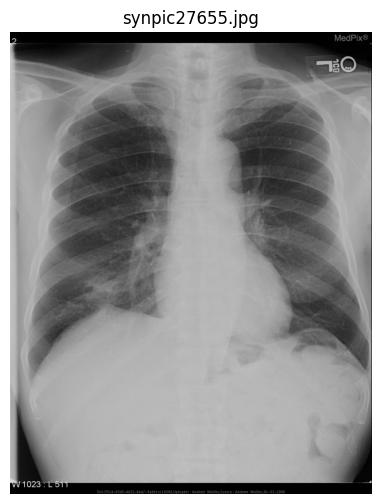

Model Text TOP 3 Matches :  CHEST X-ray, ABDOMEN CT, HEAD MRI, 

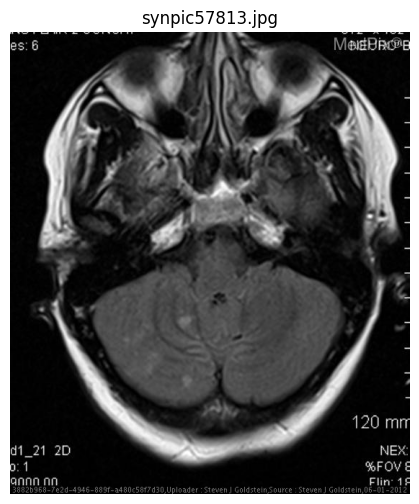

Model Text TOP 3 Matches :  HEAD MRI, CHEST X-ray, ABDOMEN CT, 

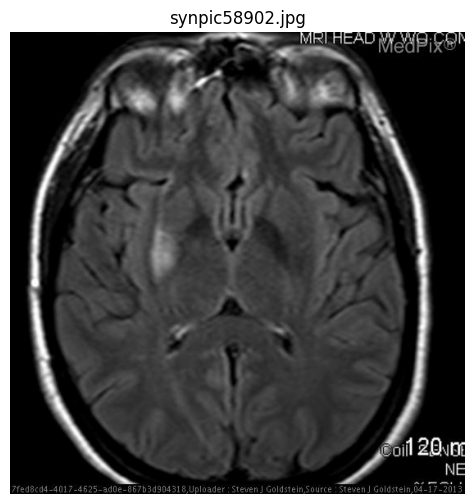

Model Text TOP 3 Matches :  HEAD MRI, CHEST X-ray, ABDOMEN CT, 

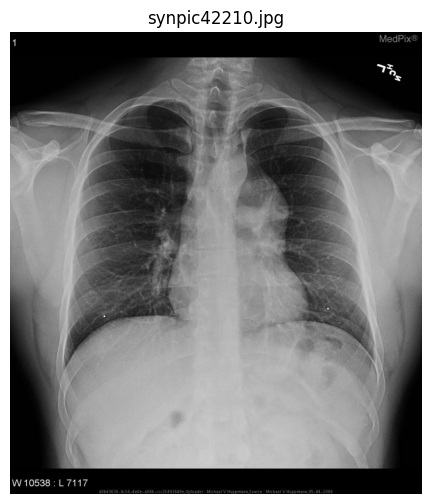

Model Text TOP 3 Matches :  CHEST X-ray, ABDOMEN CT, HEAD MRI, 

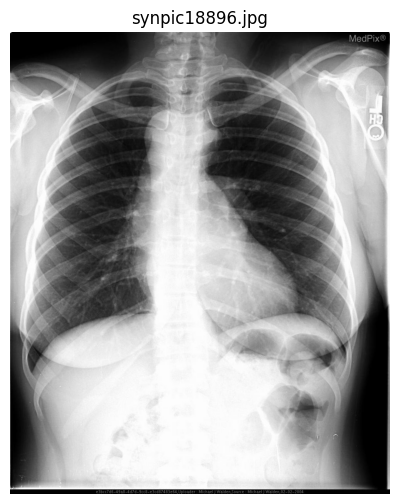

Model Text TOP 3 Matches :  CHEST X-ray, ABDOMEN CT, HEAD MRI, 

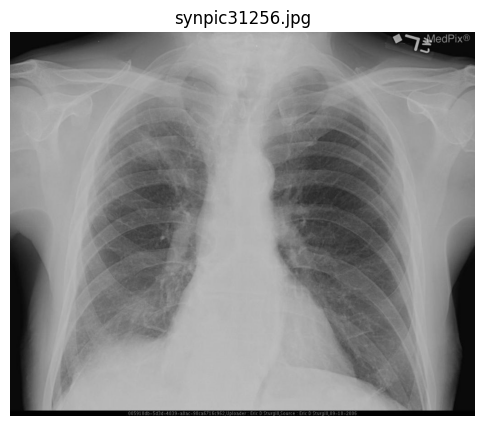

Model Text TOP 3 Matches :  CHEST X-ray, ABDOMEN CT, HEAD MRI, 

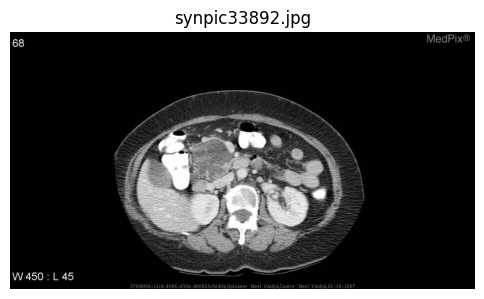

Model Text TOP 3 Matches :  ABDOMEN CT, CHEST X-ray, HEAD MRI, 

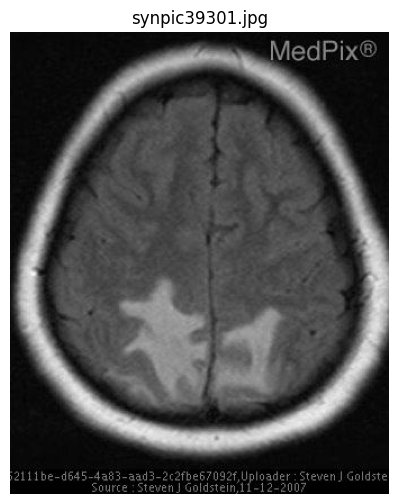

Model Text TOP 3 Matches :  HEAD MRI, CHEST X-ray, ABDOMEN CT, 

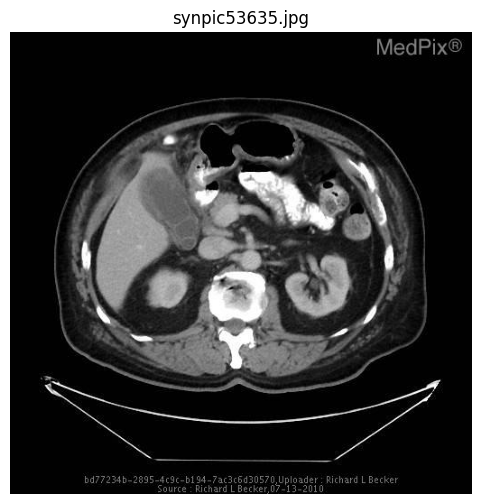

Model Text TOP 3 Matches :  ABDOMEN CT, CHEST X-ray, HEAD MRI, 

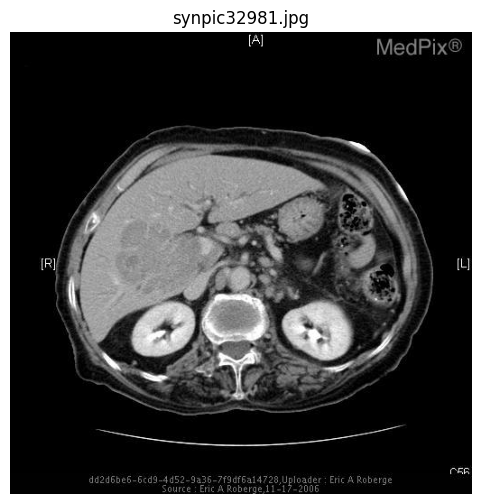

Model Text TOP 3 Matches :  ABDOMEN CT, CHEST X-ray, HEAD MRI, 

In [132]:
import torch
import torch.nn.functional as F

# your three candidate labels
texts = ["ABDOMEN CT","HEAD MRI","CHEST X-ray"]

# loop over first 10 images
for i in range(10):
    img_proj = image_proj_list[i]               # (1, D) tensor
    # compute cosine similarities to each text
    sims = torch.stack([
        F.cosine_similarity(img_proj, text_emb, dim=1).squeeze(0)
        for text_emb in text_embeddings_list
    ])  # shape: (3,)
    # turn into probabilities
    probs = F.softmax(sims, dim=0)              # (3,)
    # sort descending
    sorted_probs, idxs = torch.sort(probs, descending=True)

    # display
    # print(f"\nImage #{i+1} ({df['text'].iat[i]}):")
    image_dir=image_dirs[i]
    plot_image(image_dir)

    print("Model Text TOP 3 Matches :", end ="  ")
    for p, idx in zip(sorted_probs, idxs):
        print(texts[idx],end=", ")

